In [1]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from plot_style.style_prab import load_preset,figsize,cmap_nicify
from plot_style.style_prab import colors as colors_preset
load_preset(scale=1,font_path='../plot_style/font')
import pickle
mymap = cmap_nicify(cmap='YlGnBu_r',idx_white=1,size_white=50)
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)


matplotlib preset loaded


In [2]:
path = '../data/dataframe_combined_xspec_interpolated_gaia_energy_2022.h5'
df_xspec = pd.read_hdf(path)[:-1]

path = '../data/dataframe_combined_espec_interpolated_gaia_energy_2022.h5'
df_espec = pd.read_hdf(path)[:-1]

Text(0, 0.5, '1st order width')

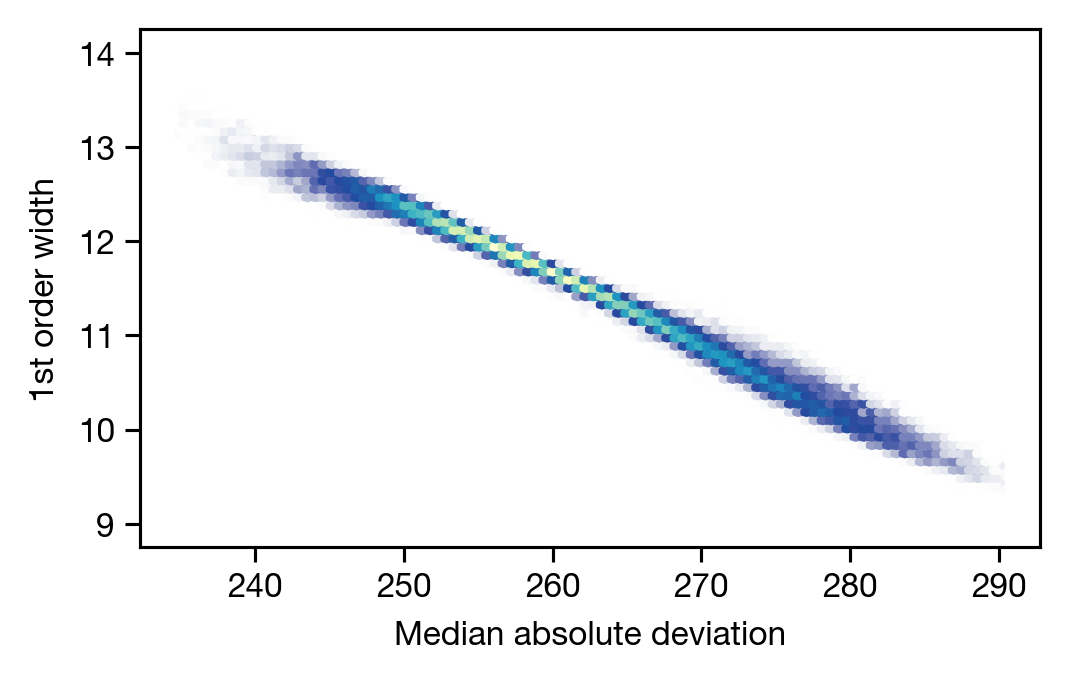

In [3]:
# check if diagnostics are synced
f = df_espec['bpm2_q'] > 10
f = df_xspec['bpm2_q'] > 10
nonan = ~df_espec['espec_high_energy_median'].isna() & ~df_xspec['xspec_1st_order_wavelangth'].isna()
f = f & nonan

x = df_espec['espec_high_energy_median'][f]
y = df_espec['xspec_1st_order_wavelangth'][f]

plt.hexbin(x,y,cmap=mymap,bins=500, extent = (235,290,9,14)) #extent = (1,15,1,3),bins=50)
plt.xlabel('Median absolute deviation')
plt.ylabel('1st order width')

In [29]:
# remove all nan-shots from xspec-data
nonan = ~pd.isna(df_xspec['xspec_spectrum'])
df_xspecx = df_xspec['xspec_spectrum'][nonan].to_frame()

# join espec and xspec on shotid
joint = df_espec.join(df_xspecx,on='shotid')
joint = joint.sort_values(by='espec_high_energy_median',ascending=True)
nonan = ~pd.isna(joint['xspec_1st_order_wavelangth'])
joint = joint[nonan]

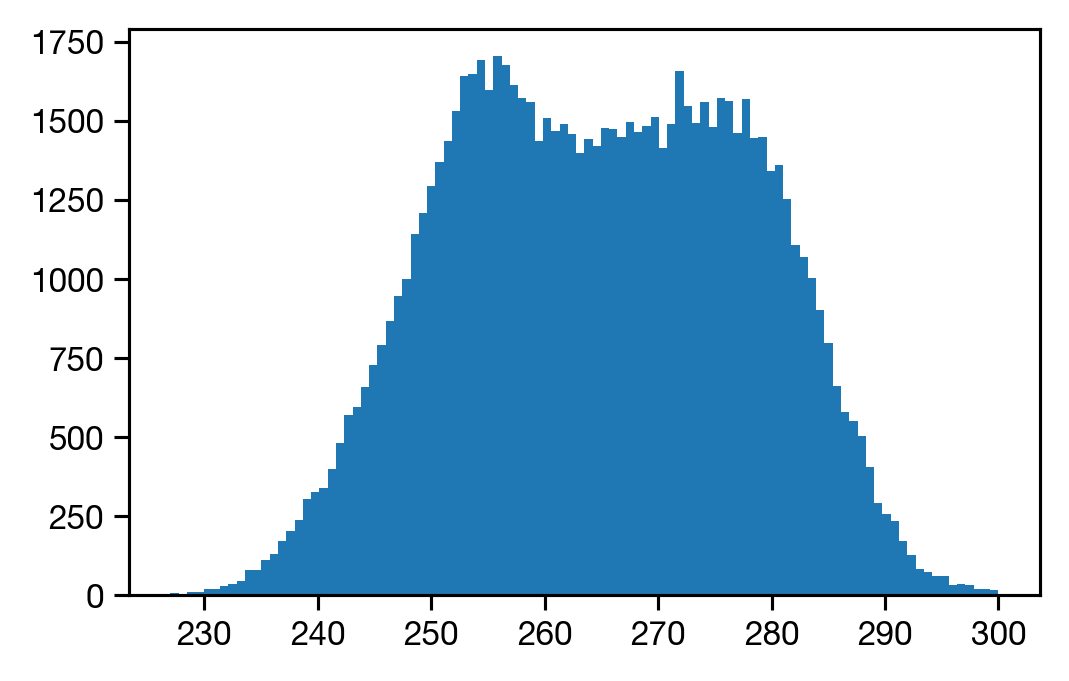

In [30]:
# create bins
n = 100
counts,bins,_ = plt.hist(joint['espec_high_energy_median'].values,bins=n,range=[227,300])

In [37]:
wfp = np.zeros((n+1,1024//2-300))
y = []

for i,row in enumerate(joint.iterrows()):
    E,wl_spec,_ = row[1]['espec_high_energy_median'],row[1]['xspec_spectrum'],row[1]['xspec_1st_order_wavelangth']
    for j in range(1,bins.shape[0]):
        if E>bins[j-1] and E<bins[j]:
            wfp[j,:] += wl_spec[1024//2:-300]
            break
wfp = wfp[1:,:]
wfp = wfp/counts[:,np.newaxis]


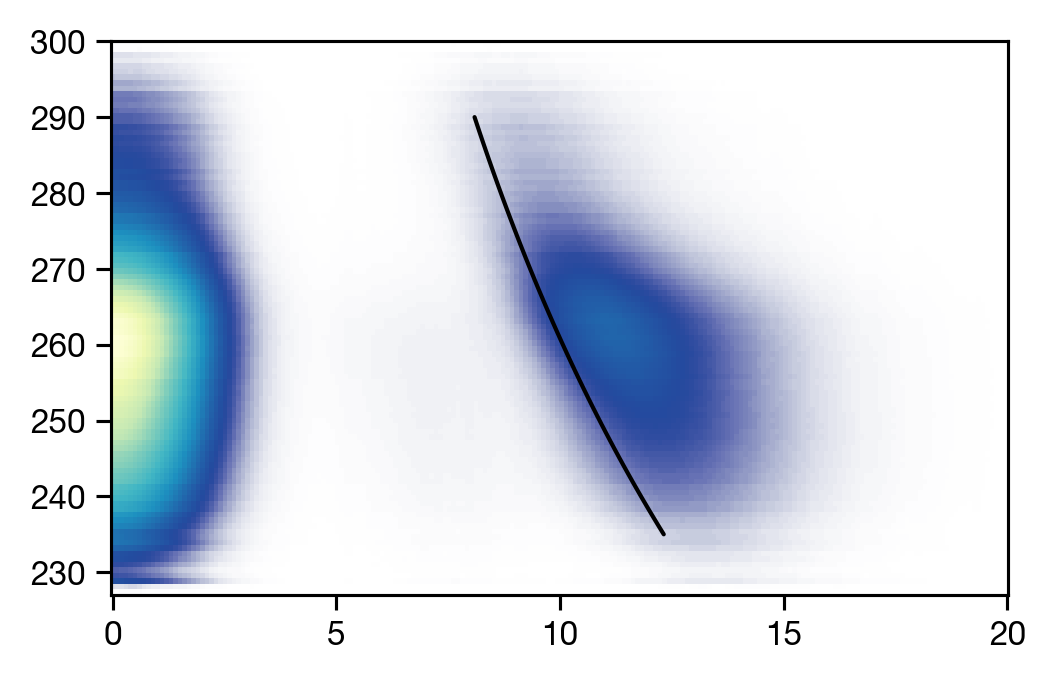

In [38]:
wl = np.load('../data/wavelength_axis.npy')
y = bins[1:]-np.diff(bins)[0]/2
plt.pcolormesh(wl[1024//2+12:-300]-wl[1024//2+12],y,wfp[:,12:],cmap=mymap)

wl_u = 5e6 # nm
K = 0.29 #0.29 # unitless
mec2 = 0.511 #MeV 

# undulator eq
def xray_wl(E):
    return (wl_u*mec2**2/(2*(E)**2))*(1+K**2/2) 

E = np.linspace(235,290)
xwl = xray_wl(E)
plt.plot(xwl,E,'k',label='Undulator eq.')


In [44]:
# remove all nan-shots from xspec-data
nonan = ~pd.isna(df_xspec['xspec_spectrum'])
df_xspecx = df_xspec['xspec_spectrum'][nonan].to_frame()

# join espec and xspec on shotid
joint = df_espec.join(df_xspecx,on='shotid')
joint = joint.sort_values(by='espec_high_energy_mad',ascending=True)
nonan = ~pd.isna(joint['xspec_1st_order_wavelangth'])
joint = joint[nonan]

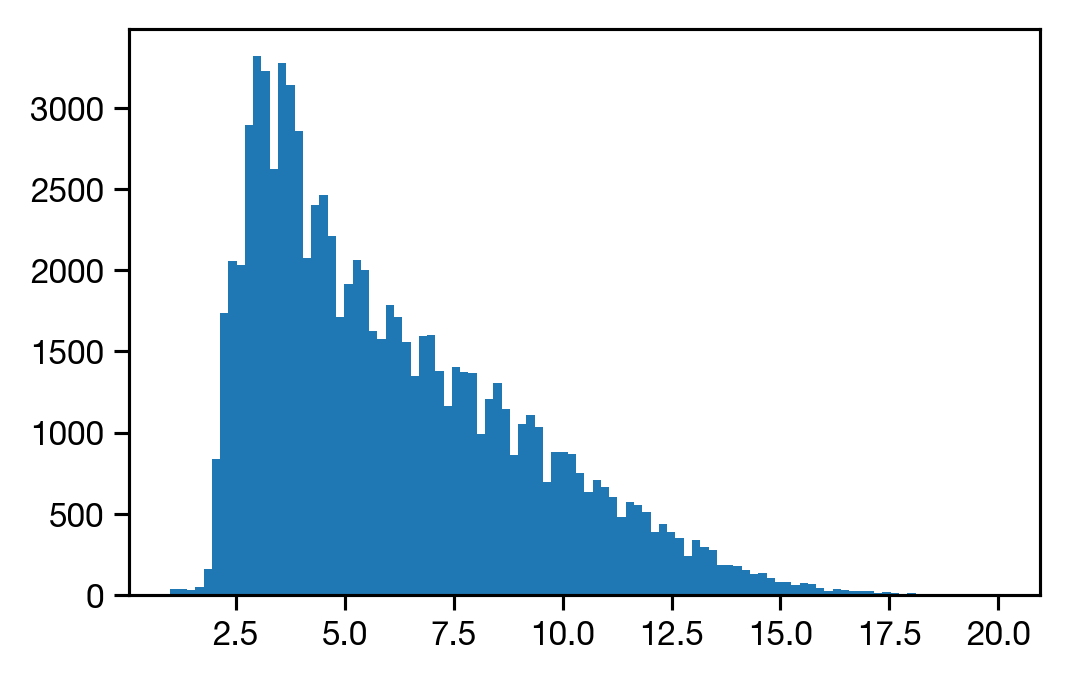

In [45]:
# create bins
n = 100
counts,bins,_ = plt.hist(joint['espec_high_energy_mad'].values,bins=n,range=[1,20])

In [68]:
wfp = np.zeros((n+1,1024//2-300))
y = []

for i,row in enumerate(joint.iterrows()):
    E,wl_spec,_ = row[1]['espec_high_energy_mad'],row[1]['xspec_spectrum'],row[1]['xspec_1st_order_wavelangth']
    for j in range(1,bins.shape[0]):
        if E>bins[j-1] and E<bins[j]:
            m = np.max(wl_spec[1024//2:-300])
            wfp[j,:] += wl_spec[1024//2:-300]/m
            break
wfp = wfp[1:,:]
wfp = wfp/counts[:,np.newaxis]

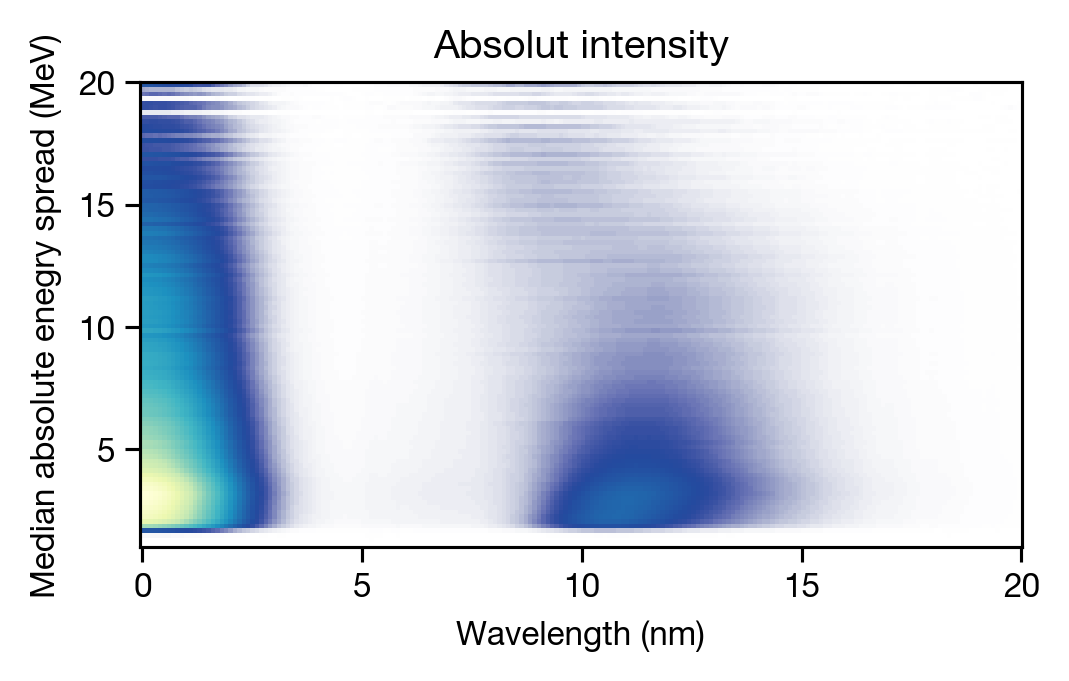

In [67]:
wl = np.load('../data/wavelength_axis.npy')
y = bins[1:]-np.diff(bins)[0]/2
plt.pcolormesh(wl[1024//2+12:-300]-wl[1024//2+12],y,wfp[:,12:],cmap=mymap)


plt.xlabel('Wavelength (nm)')
plt.ylabel('Median absolute enegry spread (MeV)')
plt.title('Absolut intensity')
plt.savefig('MAD_xray_spectrum_intensity.png')

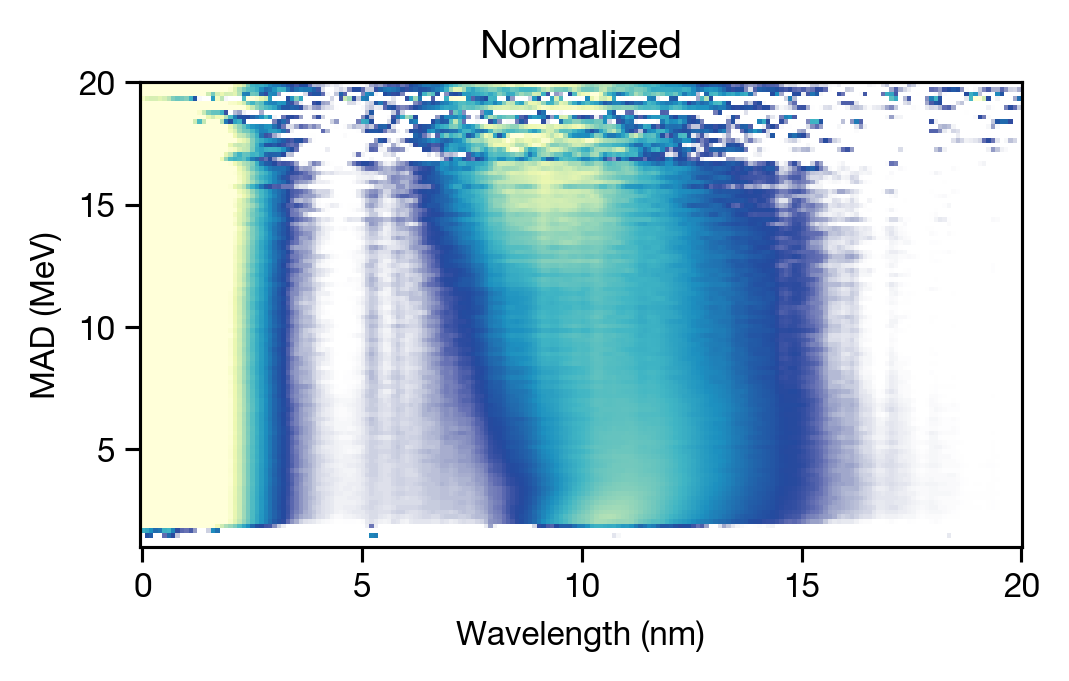

In [69]:
wl = np.load('../data/wavelength_axis.npy')
y = bins[1:]-np.diff(bins)[0]/2
plt.pcolormesh(wl[1024//2+12:-300]-wl[1024//2+12],y,wfp[:,12:],cmap=mymap,vmin=0,vmax=0.4)


plt.xlabel('Wavelength (nm)')
plt.ylabel('MAD (MeV)')
plt.title('Normalized')
plt.savefig('MAD_xray_spectrum_normalized.png')

In [53]:
wfp[:,12:].min()

-0.9842745709454427